## Higgs Boson ML Challenge

URL: [https://www.kaggle.com/c/higgs-boson/overview](https://www.kaggle.com/c/higgs-boson/overview)

In this challenge, we are given two types of signals, a signficant signal that has features of a tau-tau decay, and a background signal that has no significance. The signal is usually deeply burried in the noise, so is difficult to identify. The goal is to use machine learning to help identify the significant traces from the background traces with nothing of significance

### Importing libraries and data

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import os

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
dirpath = os.path.dirname(os.path.realpath('__file__'))
train_data = pd.read_csv(dirpath + '/training/training.csv')
val_data = pd.read_csv(dirpath + '/test/test.csv')

cols = train_data.columns.values
X_train, X_test, y_train, y_test = train_test_split(train_data[cols[:-1]], train_data[cols[-1]], 
                                                    test_size=.2, random_state=10)

### Data cleaning and pre-processing

We first do some data cleaning and other housekeeping. The first order of business is to check if there are any non-numeric types and encode them into numeric types (if any). It turns out that the `Label` column is in fact a string so we Binarize that. Furthermore, we want to drop any columns that do not have any predictive power, for example the `EventId` column. Finally, we want to normalize all the data between -1 and 1, just to make sure that no particular column has too much weight. For this we use the `MinMaxScaler` class from `sklearn.preprocessing`. We will do this be defining a function so that we can modularize the processes to both the training data as well as the test data.

In [3]:
train_data['Label'] = np.where(train_data['Label']=='b', 0.0, 1.0) # Convert string label to float
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.drop(columns='EventId', axis=0, inplace=True)
test_data.drop(columns='EventId', axis=0, inplace=True)
print(train_data.shape) # Print the number of entries in the dataset
# train_data


(200000, 32)


In [4]:
# Encoding the labels from string to integer
train_data['Label'] = np.where(train_data['Label']=='b', 0, 1)
test_data['Label'] = np.where(test_data['Label']=='b', 0, 1)

We note that there are a ton of entries that have -999.000 as the entry. This is a dummy number that yielded unphysical data. Let us first see what happens if we simply drop all rows that have a -999.000 entry in one of its columns. Do we lose too much of the data?

In [5]:
train_data_nan = train_data.replace(-999.000, np.nan)
test_data_nan = test_data.replace(-999.000, np.nan)
train_data_dropped = train_data_nan.dropna()
train_data_dropped.shape

(54500, 32)

Yes! We went from 200000 entires to only 54500 entries. That is a huge loss of data. So  the strategy we are going to take is the following: we will first define a new dataset that drops all the -999.000 entries and then calculates the min and max value for each column. We then replace each -999.000 entry in a column with the a random number that lies between the min and max values of that column. Finally, we will scale all columns using a `MinMaxScaler` so that no single column runs away or dominates the fitting routines. We define all these operations in a function so that we can apply the same operations to the train set as well as the test set. 

In [6]:
def min_max(col):
    return np.nanmin(col, axis=0), np.nanmax(col, axis=0)

def data_preprocessor(data):
    """
    Pre-processes and cleans up the data.
    args:
        X_data: all the feature columns except the label
        y_data: the data labels, dtype: str
    returns:
        Dataframe that is normalized
    """
    # See if there is a apply_along_axis solution exists
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.apply_along_axis.html
    # Otherwise do the stupid way of looking at each value. This might be very slow.
    # Ask on stack exchange
    rows = data.shape[0]
    for col in data.columns:
        minv, maxv = min_max(data[col])
        binary_col = np.isnan(data[col])*1
        # print(binary_col.shape)
        random_col = np.random.uniform(low=minv, high=maxv, size=rows)
        corrected_col = (binary_col*random_col).values.reshape(-1,1)
        orig_col = data[col].values.reshape(-1, 1)
        s = np.nansum([orig_col, corrected_col], axis=0)
        data[col] = s
    return data

corrected_train_data = data_preprocessor(train_data_nan)
corrected_test_data = data_preprocessor(test_data_nan)

Our next order of business is to use the `MinMaxScaler` so that no one feature runs away with too much predictive power. 

In [7]:
scaler = MinMaxScaler()

def scaling_function(data):
    fitted_data = scaler.fit(data)
    scaled_data = scaler.transform(data)

    return scaled_data

scaled_train_data = scaling_function(corrected_train_data) # numpy ndarray
scaled_test_data = scaling_function(corrected_test_data) # numpy ndarray

### Defining a custom `Dataset` object

Now that we have cleaned and scaled both the training and the test data, we can now proceed to define a `Dataset` object that would help make batches and treat data more efficiently

In [8]:
class HiggsDataset(Dataset):

    def __init__(self, data):
        super(HiggsDataset, self).__init__()
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, x):
        features = self.data[x,:-1].reshape(1, -1)
        label = self.data[x,-1].reshape(1,-1)
        return torch.Tensor(features), torch.tensor(label).long()


In [9]:
TRAIN_BATCH_SIZE = 50
train_data_dataset = HiggsDataset(scaled_train_data)
train_data_dataloader = DataLoader(train_data_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_data_dataset = HiggsDataset(scaled_test_data)
test_data_dataloader = DataLoader(test_data_dataset, batch_size=1, shuffle=True)

### Defining the neural network architecture

At this point, we have cleaned and scaled our input data and also created a `Dataset` class as well as a `Dataloader` object to feed the data into the neural network. All that remains is to now define the architecture of our Neural Network, write the training loop and make predictions to see if we are any more accurate.  We are going to define our architecture as having five layers with the progression of the number of nodes in each layer being 31 -> 64 -> 128 -> 64 -> 32 -> 2. The two output notes denotes the probability that the example is background noise or significant. i.e. the argmax being 0 or 1 denotes noise and significance respectively. 

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(31, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        # x = self.softmax(x)

        return x.reshape(-1, 2)

        

In [14]:
# Instantiating the neural net, the optimzer and the loos funciton

net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=.0001)
objective_fn = nn.CrossEntropyLoss()


### Defining the training loop 

100%|██████████| 4000/4000 [00:46<00:00, 85.95it/s]
0.003012334327566787
100%|██████████| 4000/4000 [01:03<00:00, 63.46it/s]
0.0002721146285043687
100%|██████████| 4000/4000 [00:47<00:00, 84.54it/s]
6.55438309364404e-05
100%|██████████| 4000/4000 [00:43<00:00, 91.18it/s]
7.343837929607503e-05
100%|██████████| 4000/4000 [00:43<00:00, 92.64it/s]
4.396566359647231e-05
100%|██████████| 4000/4000 [00:43<00:00, 92.47it/s]
5.3942677738656394e-05
100%|██████████| 4000/4000 [00:46<00:00, 86.06it/s]
1.6442025407632083e-05
100%|██████████| 4000/4000 [00:43<00:00, 90.94it/s]
5.132545408402447e-05
100%|██████████| 4000/4000 [00:45<00:00, 87.85it/s]
1.7777175188546578e-05
100%|██████████| 4000/4000 [00:44<00:00, 89.63it/s]
1.663025830395218e-05
100%|██████████| 4000/4000 [00:44<00:00, 89.78it/s]
4.742548016014325e-07
100%|██████████| 4000/4000 [00:45<00:00, 88.48it/s]
5.347383280361804e-05
100%|██████████| 4000/4000 [00:44<00:00, 90.07it/s]
9.662710828496386e-05
100%|██████████| 4000/4000 [00:44<00:

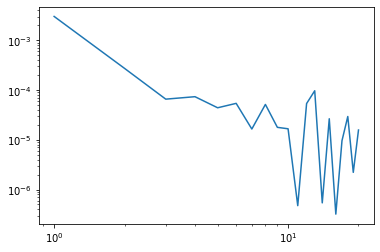

In [15]:
# Defining the train function

NUM_EPOCHS = 20
def train():
    loss_matrix = []
    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        for data in tqdm(train_data_dataloader):
            features, label = data[0].to(device), data[1].reshape(-1).to(device)
            output = net(features)
            optimizer.zero_grad()
            loss = objective_fn(output, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss = total_loss/(len(train_data_dataloader)*TRAIN_BATCH_SIZE)
        loss_matrix.append(total_loss)
        print(total_loss)
    return loss_matrix

loss_matrix = train()
plt.loglog(1 + np.arange(len(loss_matrix)), loss_matrix)

### Making predictions on test data and calculating an accuracy score

In [16]:
# Accuracy:
num_data = len(test_data_dataloader)
correct = 0

for test_data_example, test_label in tqdm(test_data_dataloader):
    pred = torch.argmax(net(test_data_example.to(device))).item()
    target = test_label.item()
    if pred == target:
        correct += 1 
print('Accuracy: ', correct*100/num_data)

100%|██████████| 50000/50000 [00:22<00:00, 2202.06it/s]
Accuracy:99.87


We see that we get an accuracy score of close to 99.5%, indicating that our neural network does a great job at distinguishing between noise and significance in the test set. 